In [1]:
%load_ext autoreload

In [87]:
import os
import sys

import numpy as np
from natsort import natsorted

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import kinectmatics as km

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt

In [230]:
def _plot_rect_movement(ax, _ranges, _time, xlim=None):
        
    names = ('Threshold layer', 'Merge layer', 'Rejection layer', 'Output layer')
    colors = ('k', 'b', 'r', 'k')
    alpha = [0.5, 1.0, 1.0, 1.0]
    height = 1.0
    ind_start = height * np.array([3, 2, 1, 0])

    yticks = []

    for ind, (_range, c, name, i_start, a) in enumerate(zip(_ranges, colors, names, ind_start, alpha)):
        floor = i_start*height

        pc = _range_to_collection(_range, c, t0=_time[0], height=height, floor=floor, alpha=a)
        temp = ax.add_collection(pc)

        yticks.append(floor+height/2.)
#             break
    ax.set_yticks(yticks)
    ax.set_yticklabels(names)

    ax.set_title('Movement Segments in Video')
    ax.set_xlabel('Video Time (seconds)')

    if xlim is None:
        ax.set_xlim(0, _time[-1]-_time[0])
    else:
        ax.set_xlim(xlim)
    ax.set_ylim(0, ind_start[0]+height)

    ax.grid(False)

    return ax

def _range_to_collection(ran, c, t0=0, height=1, floor=0, alpha=1):
            
    from matplotlib.patches import Rectangle
    from matplotlib.collections import PatchCollection
    
    segmentboxes = []

    if len(ran) > 0:
        for i, r in ran.iterrows():
    #         if r['duration'] > 100: continue

            t_on = r['onset'] - t0
            t_off = t_on + r['duration']

            rect = Rectangle((t_on, floor), t_off-t_on, height, facecolor=c)
            segmentboxes.append(rect)

    pc = PatchCollection(segmentboxes, alpha=alpha, facecolor=c)
    return pc

In [232]:
# synthetic signal
signal = np.zeros(int(1e3),)
# signal_merge =  np.zeros(201,)
# signal_isol =  np.zeros(201,)

# synthetic timestamps
Fs = 10.
t = np.arange(0, len(signal)/Fs, 1/Fs)

# generate "true signal"
signal[800:] = 1 # 'Rest 1'
signal[600:660] = 1 # 'Still 1'
signal[750:790] = 1 # 'Still 2'

signal[175:182] = 1 # 'Move 1'
signal[192:200] = 1 # 'Move 2'
signal[150:169] = 1 # 'Move 3'
signal[102:110] = 1 # 'Move 4, short and alone'


# # keep only true signal
# signal_true[210:250] = 1
# # signal_true[300:314] = 1
# signal_true[300:302] = 1
# signal_true[304:314] = 1
# signal_true[404:414] = 1

# # inject artificact and random noise
signal[417:419] = 1
signal[420:422] = 1
signal[681:688] = 1
# signal[708:714] = 1
signal += np.abs(np.random.random_sample(len(signal),))*0.35

# # keep only noise signal
# signal_noise[417:419] = 1
# signal_noise[420:422] = 1
# signal_noise[302:304] = -1

# signal_raw = np.copy(signal)



# # filter yo' signal
signal_thresh = km.threshold_signal(signal, thresh = 0.35)
onset_input = km.array_to_sequence(signal_thresh)

# # merge neighboring cells
signal_merged = km.merge_neighboring_cells(signal_thresh, min_spacing=20)
onset_layer1 = km.array_to_sequence(signal_merged)

# # drop short cells
signal_merged_noisolated = km.filter_isolated_cells(signal_merged, struct=None, len_isolation=10)
onset_final = km.array_to_sequence(signal_merged_noisolated)

# For plot cleaning
i_merged_new = np.where(np.logical_and(signal_merged, np.logical_not(signal_thresh)))

signal_isolated = np.logical_and(np.logical_not(signal_merged_noisolated), signal_thresh)
i_iso = np.where(signal_isolated)
onset_layer2 = km.array_to_sequence(signal_isolated)

# i_iso = np.ravel(natsorted(np.array(np.concatenate([i_iso, [i_iso[0]-1,i_iso[-1]+1]]), dtype=np.int64)))

i_merged = np.where(np.logical_or(signal_merged, signal_thresh))
# i_merged = np.setdiff1d(i_merged, i_iso)
# i_merged = np.ravel(natsorted(np.array(np.concatenate([i_merged, [i_merged[0]-1,i_merged[-1]+1]]), dtype=np.int64)))

i_final = np.where(signal_merged_noisolated)
i_start = np.where(signal_thresh)

# signal_merged_noisolated[np.logical_and(signal_merged_noisolated, signal_thresh)] = 0
# signal_merged_noisolated[signal_merged==0] = np.nan

# print(i_merged)
# print(i_iso)

ranges = (onset_input, onset_layer1, onset_layer2, onset_final)


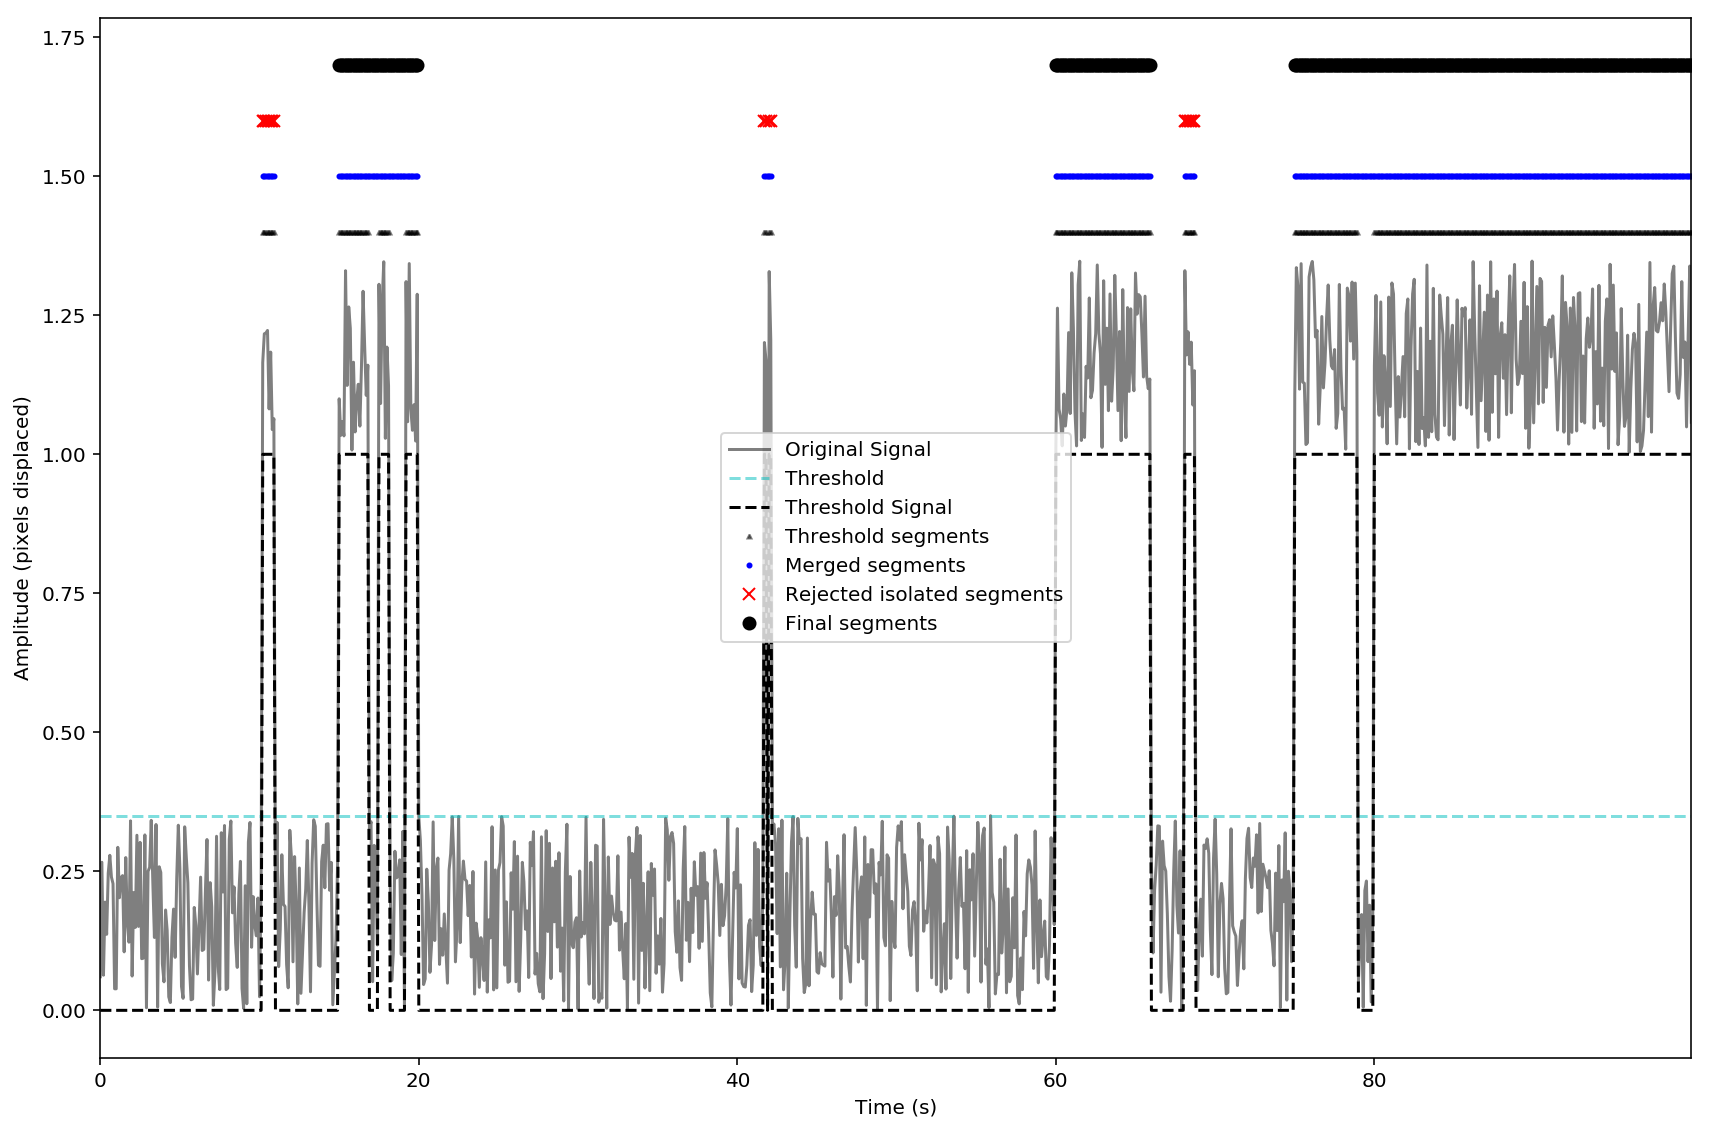

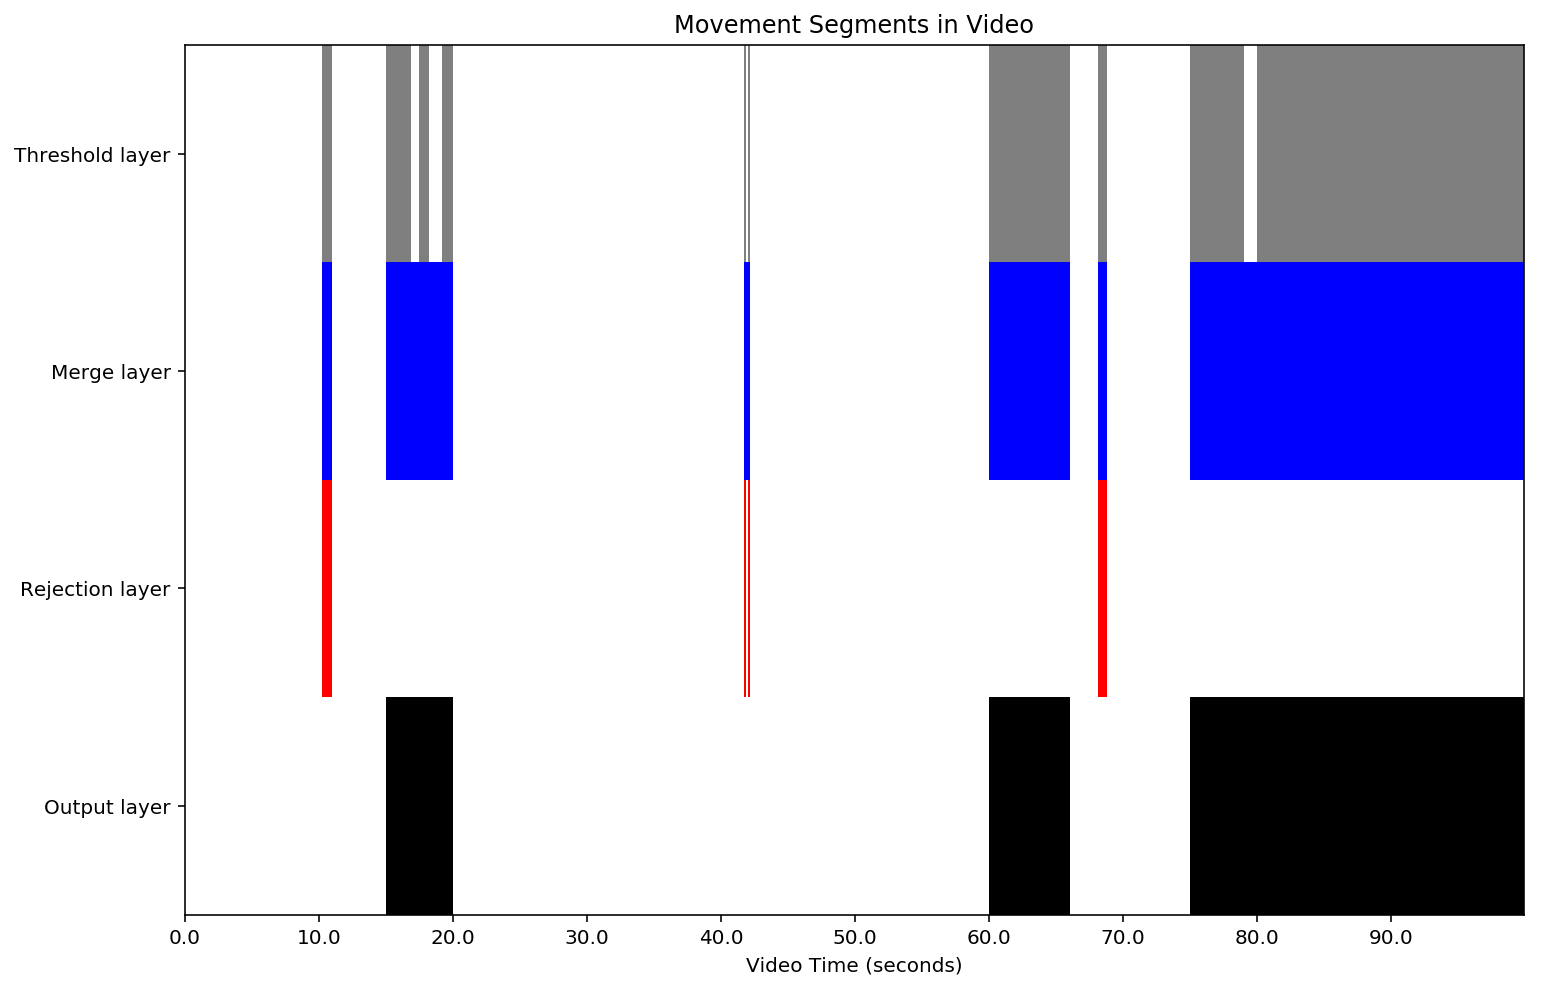

In [233]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(t, signal, 'k', alpha=0.5, label='Original Signal')
ax.plot(t, 0.35*np.ones(len(signal)), 'c--', alpha=0.5, label='Threshold')
ax.plot(t, signal_thresh, 'k--', alpha=1.0, label='Threshold Signal')

ax.plot(t[i_start], 1.4*signal_thresh[i_start], 'k^', markersize=2.0, alpha=0.5, label='Threshold segments')
ax.plot(t[i_merged], 1.5*signal_merged[i_merged], 'bo', markersize=2.0, alpha=1.0, label='Merged segments')
ax.plot(t[i_iso], 1.6*signal_thresh[i_iso], 'rx', alpha=1.0, label='Rejected isolated segments')
ax.plot(t[i_final], 1.7*signal_merged_noisolated[i_final], 'ko', alpha=1.0, label='Final segments')

# ax.plot(t, 0*t, 'k', alpha=1.0)

# ax.plot(t, i_merged], 'bo--', markersize=2.0, alpha=1.0, label='Merged segments')


ax.set_xlim(t[0], t[-1])
# plt.ylim(min(signal), max(signal))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (pixels displaced)');

ax.legend(frameon=True)



plt.tight_layout()


fig, ax = plt.subplots(1,1,figsize=(12,8))

ax = _plot_rect_movement(ax, ranges, _time=np.arange(len(t)))

inds = np.arange(0, len(t), 100)
ax.set_xticks(inds)
ax.set_xticklabels(np.round(t[inds]));

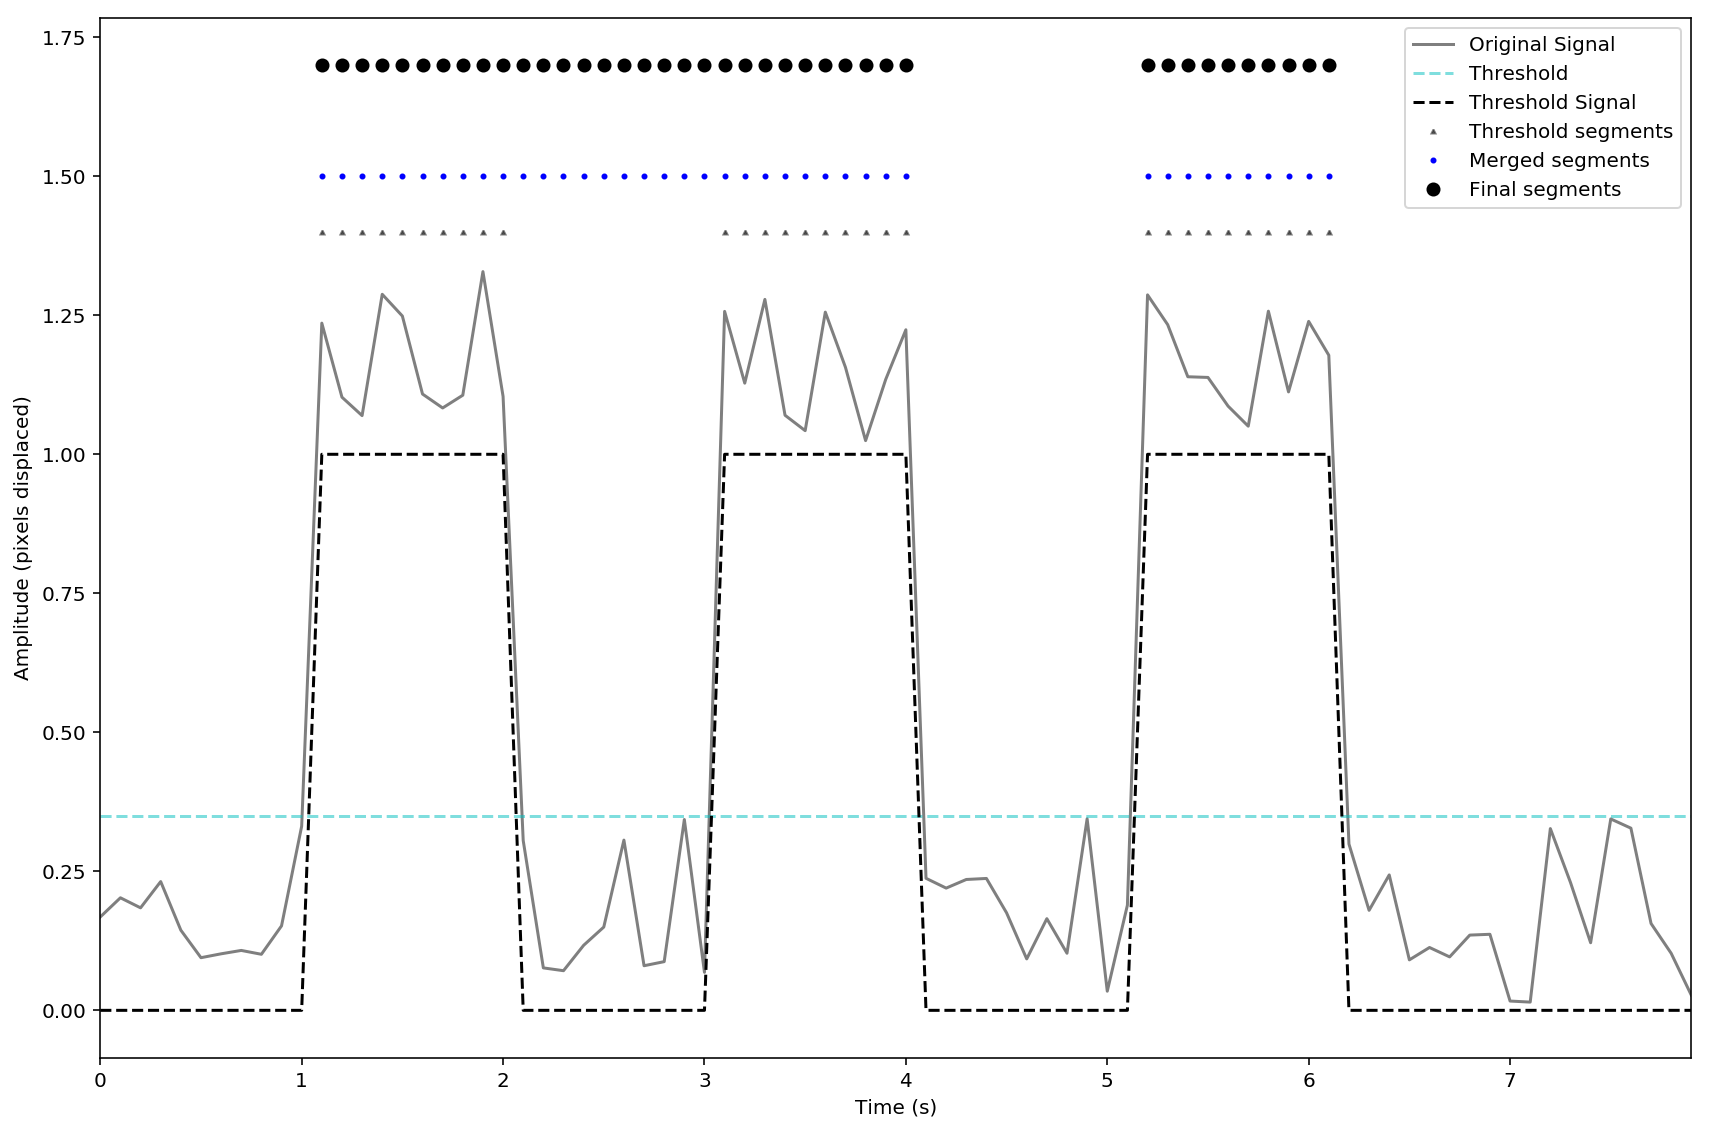

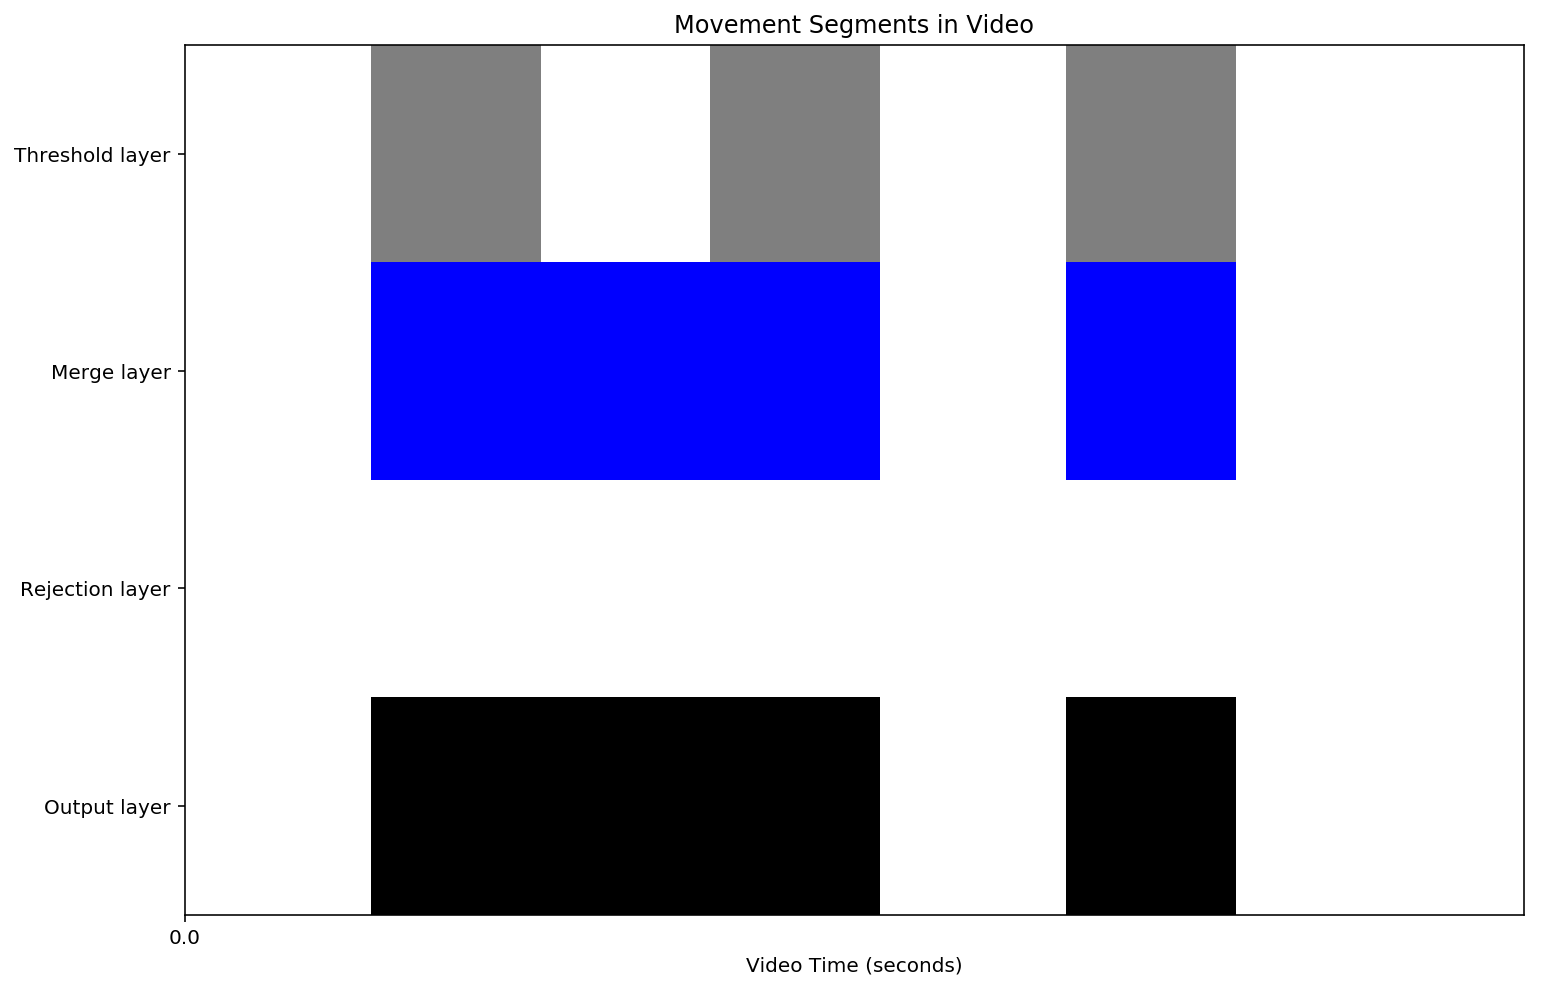

In [264]:
# synthetic signal
signal = np.zeros(int(8e1),)
# signal_merge =  np.zeros(201,)
# signal_isol =  np.zeros(201,)

# synthetic timestamps
Fs = 10.
t = np.arange(0, len(signal)/Fs, 1/Fs)

min_spacing = 10
i_start = min_spacing + 1
w_dummy = np.arange(0,10).astype(int)

# generate "true signal"
signal[w_dummy + i_start] = 1 # 'Merge 1'
signal[w_dummy + (i_start + len(w_dummy) + min_spacing)] = 1 # 'Merge 2'
signal[w_dummy + (i_start + len(w_dummy)*2 + min_spacing*2 + 1)] = 1 # 'Merge 3'

signal += np.abs(np.random.random_sample(len(signal),))*0.35

# # filter yo' signal
signal_thresh = km.threshold_signal(signal, thresh = 0.35)
onset_input = km.array_to_sequence(signal_thresh)

# # merge neighboring cells
signal_merged = km.merge_neighboring_cells(signal_thresh, min_spacing=min_spacing)
onset_layer1 = km.array_to_sequence(signal_merged)

# # drop short cells
signal_merged_noisolated = km.filter_isolated_cells(signal_merged, struct=None, len_isolation=1)
onset_final = km.array_to_sequence(signal_merged_noisolated)

# For plot cleaning
i_merged_new = np.where(np.logical_and(signal_merged, np.logical_not(signal_thresh)))

signal_isolated = np.logical_and(np.logical_not(signal_merged_noisolated), signal_thresh)
i_iso = np.where(signal_isolated)

onset_layer2 = []#km.array_to_sequence(signal_isolated)

i_merged = np.where(np.logical_or(signal_merged, signal_thresh))

i_final = np.where(signal_merged_noisolated)
i_start = np.where(signal_thresh)

ranges = (onset_input, onset_layer1, onset_layer2, onset_final)

fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(t, signal, 'k', alpha=0.5, label='Original Signal')
ax.plot(t, 0.35*np.ones(len(signal)), 'c--', alpha=0.5, label='Threshold')
ax.plot(t, signal_thresh, 'k--', alpha=1.0, label='Threshold Signal')

ax.plot(t[i_start], 1.4*signal_thresh[i_start], 'k^', markersize=2.0, alpha=0.5, label='Threshold segments')
ax.plot(t[i_merged], 1.5*signal_merged[i_merged], 'bo', markersize=2.0, alpha=1.0, label='Merged segments')
# ax.plot(t[i_iso], 1.6*signal_thresh[i_iso], 'rx', alpha=1.0, label='Rejected isolated segments')
ax.plot(t[i_final], 1.7*signal_merged_noisolated[i_final], 'ko', alpha=1.0, label='Final segments')

# ax.plot(t, 0*t, 'k', alpha=1.0)

# ax.plot(t, i_merged], 'bo--', markersize=2.0, alpha=1.0, label='Merged segments')


ax.set_xlim(t[0], t[-1])
# plt.ylim(min(signal), max(signal))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (pixels displaced)');

ax.legend(frameon=True)



plt.tight_layout()


fig, ax = plt.subplots(1,1,figsize=(12,8))

ax = _plot_rect_movement(ax, ranges, _time=np.arange(len(t)))

inds = np.arange(0, len(t), 100)
ax.set_xticks(inds)
ax.set_xticklabels(np.round(t[inds]));

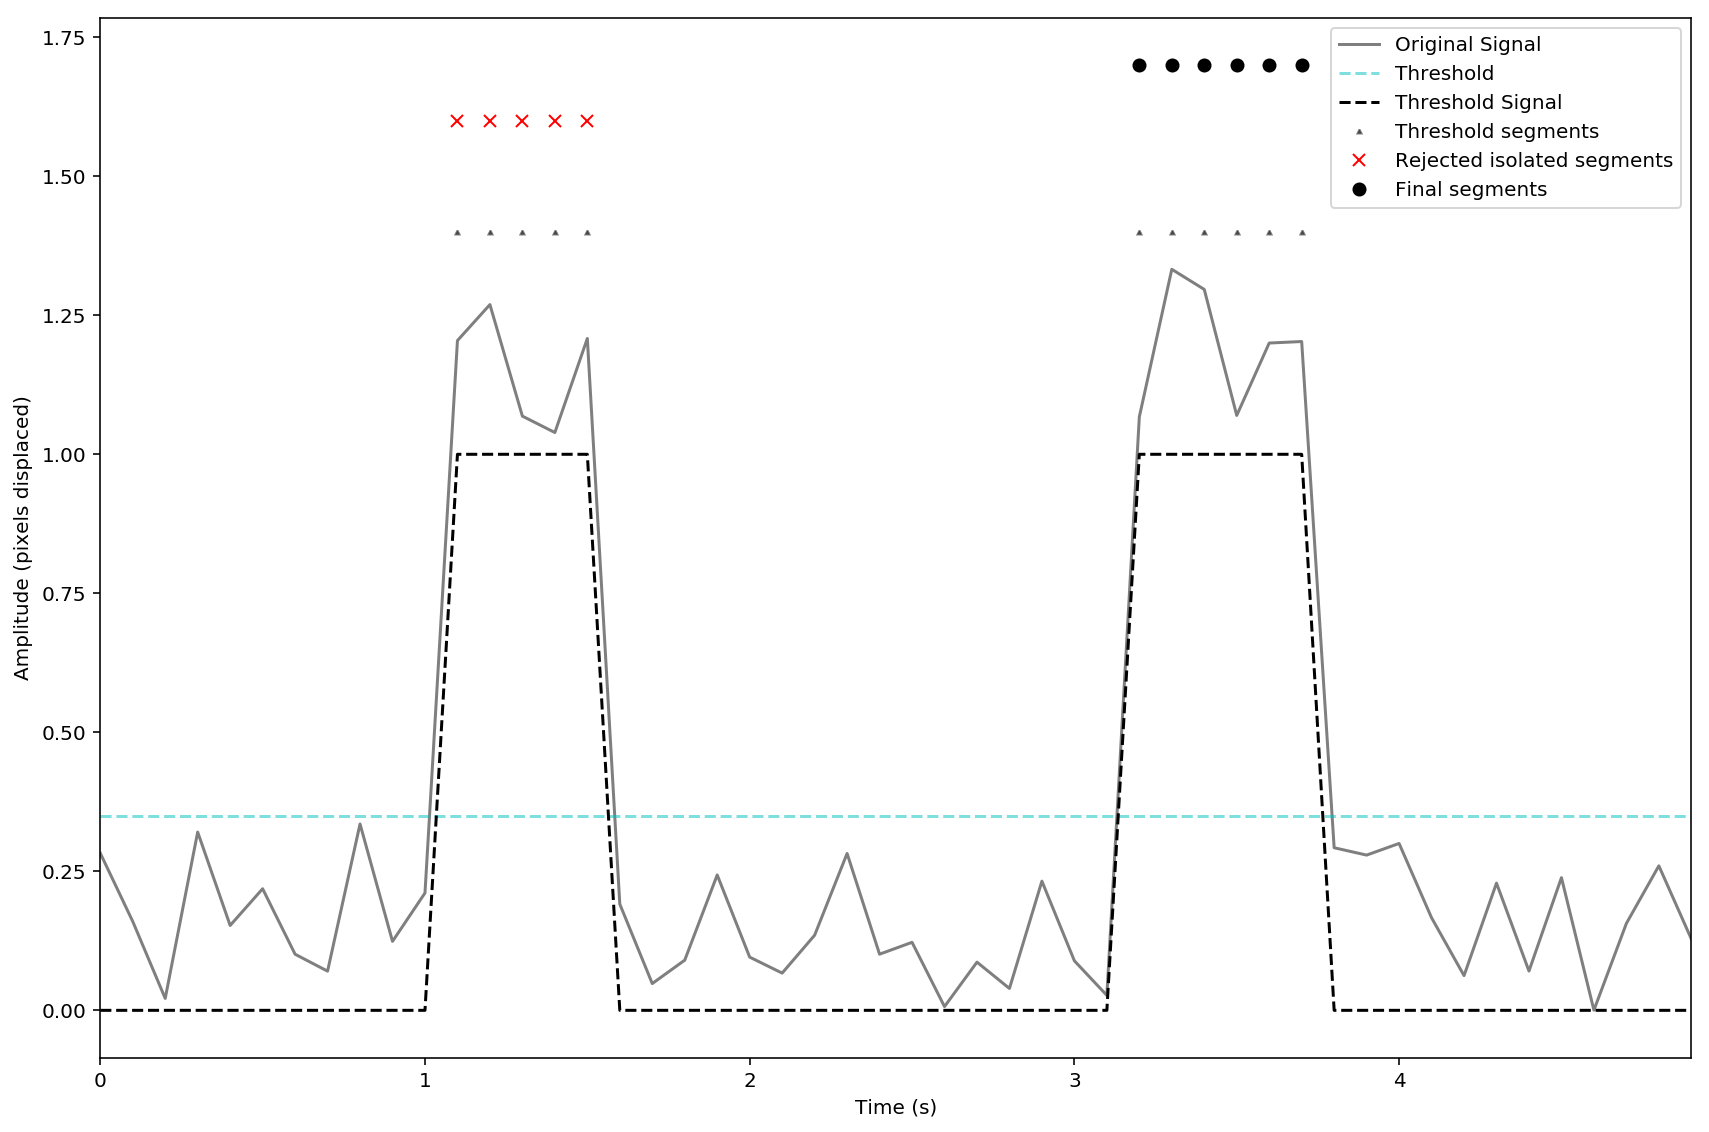

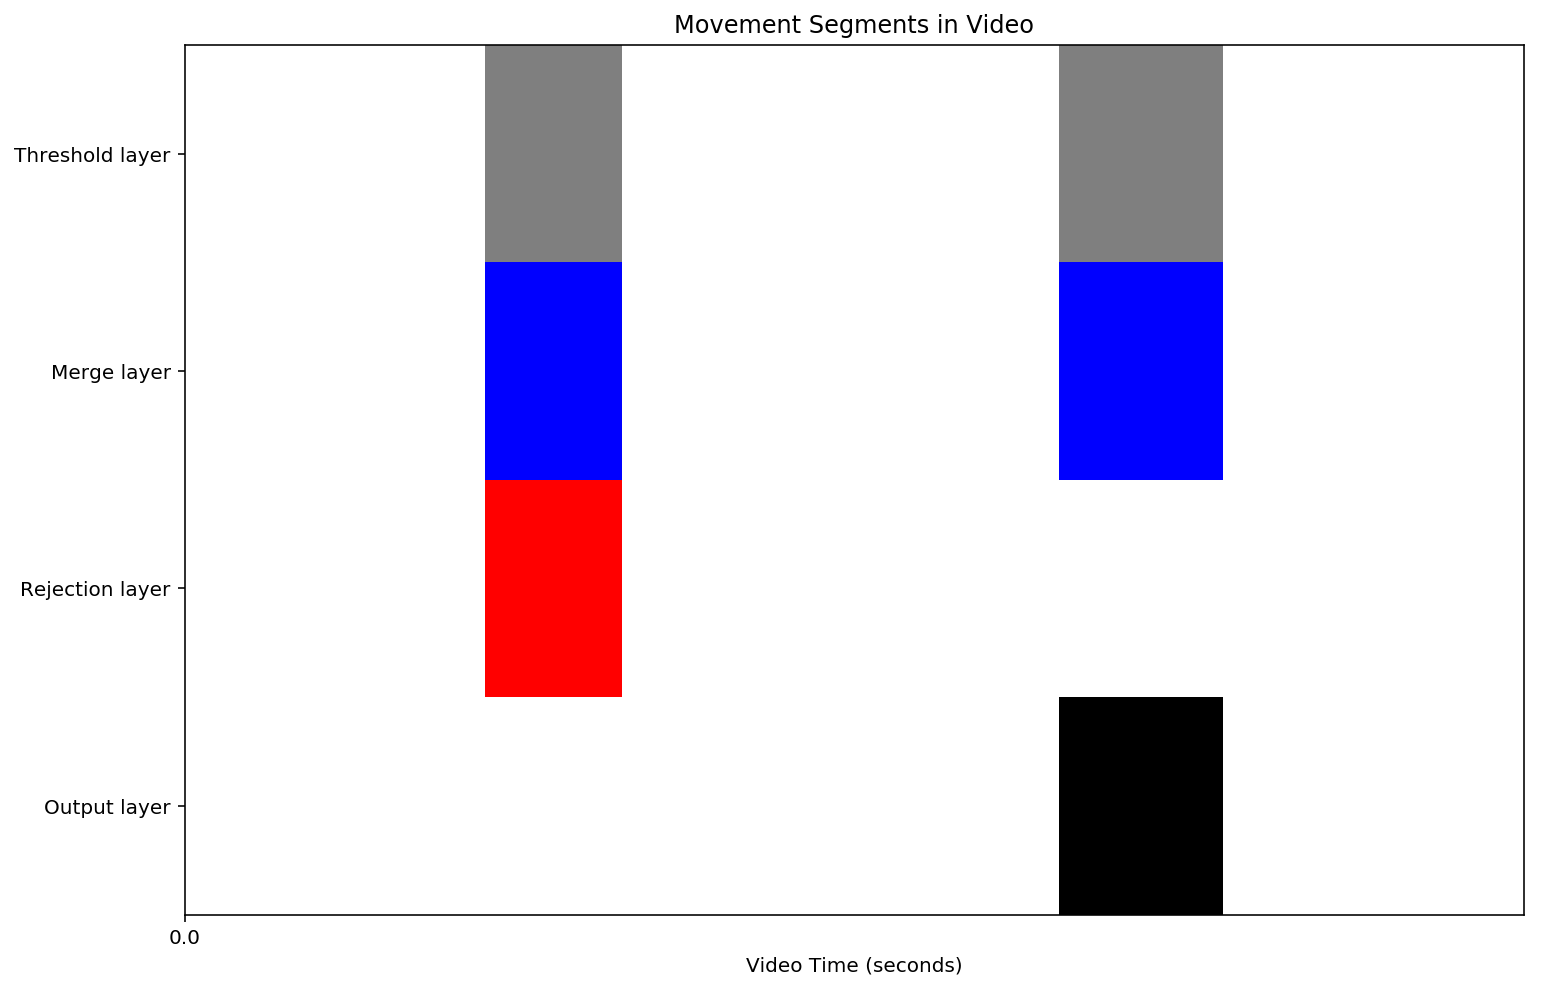

In [263]:
# synthetic signal
signal = np.zeros(int(5e1),)
# signal_merge =  np.zeros(201,)
# signal_isol =  np.zeros(201,)

# synthetic timestamps
Fs = 10.
t = np.arange(0, len(signal)/Fs, 1/Fs)

len_isolation = 5

w_dummy = np.arange(0,len_isolation).astype(int)
w_dummy2 = np.arange(0,len_isolation+1).astype(int)

i_start = 10 + 1
i_start2 = 30 + 1
# generate "true signal"
signal[w_dummy + i_start] = 1 # 'Drop 1'
signal[w_dummy2 + i_start2 + 1] = 1 # 'Drop 2'

signal += np.abs(np.random.random_sample(len(signal),))*0.35

# # filter yo' signal
signal_thresh = km.threshold_signal(signal, thresh = 0.35)
onset_input = km.array_to_sequence(signal_thresh)

# # merge neighboring cells
signal_merged = km.merge_neighboring_cells(signal_thresh, min_spacing=1)
onset_layer1 = km.array_to_sequence(signal_merged)

# # drop short cells
signal_merged_noisolated = km.filter_isolated_cells(signal_merged, struct=None, len_isolation=len_isolation)
onset_final = km.array_to_sequence(signal_merged_noisolated)

# For plot cleaning
i_merged_new = np.where(np.logical_and(signal_merged, np.logical_not(signal_thresh)))

signal_isolated = np.logical_and(np.logical_not(signal_merged_noisolated), signal_thresh)
i_iso = np.where(signal_isolated)

onset_layer2 = km.array_to_sequence(signal_isolated)

i_merged = np.where(np.logical_or(signal_merged, signal_thresh))

i_final = np.where(signal_merged_noisolated)
i_start = np.where(signal_thresh)

ranges = (onset_input, onset_layer1, onset_layer2, onset_final)

fig, ax = plt.subplots(1, 1, figsize=(12,8))

ax.plot(t, signal, 'k', alpha=0.5, label='Original Signal')
ax.plot(t, 0.35*np.ones(len(signal)), 'c--', alpha=0.5, label='Threshold')
ax.plot(t, signal_thresh, 'k--', alpha=1.0, label='Threshold Signal')

ax.plot(t[i_start], 1.4*signal_thresh[i_start], 'k^', markersize=2.0, alpha=0.5, label='Threshold segments')
# ax.plot(t[i_merged], 1.5*signal_merged[i_merged], 'bo', markersize=2.0, alpha=1.0, label='Merged segments')
ax.plot(t[i_iso], 1.6*signal_thresh[i_iso], 'rx', alpha=1.0, label='Rejected isolated segments')
ax.plot(t[i_final], 1.7*signal_merged_noisolated[i_final], 'ko', alpha=1.0, label='Final segments')

# ax.plot(t, 0*t, 'k', alpha=1.0)

# ax.plot(t, i_merged], 'bo--', markersize=2.0, alpha=1.0, label='Merged segments')


ax.set_xlim(t[0], t[-1])
# plt.ylim(min(signal), max(signal))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (pixels displaced)');

ax.legend(frameon=True)



plt.tight_layout()


fig, ax = plt.subplots(1,1,figsize=(12,8))

ax = _plot_rect_movement(ax, ranges, _time=np.arange(len(t)))

inds = np.arange(0, len(t), 100)
ax.set_xticks(inds)
ax.set_xticklabels(np.round(t[inds]));